In [7]:
import pandas as pd
import json

with open('reviews.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(
    data['paper'],
    record_path=['review'],
    meta=['id', 'preliminary_decision'],
    record_prefix='review_',
    meta_prefix='paper_'
)

print(df.head())

  review_confidence review_evaluation  review_id review_lan  \
0                 4                 1          1         es   
1                 4                 1          2         es   
2                 5                 1          3         es   
3                 4                 2          1         es   
4                 4                 2          2         es   

  review_orientation review_remarks  \
0                  0                  
1                  1                  
2                  1                  
3                  1                  
4                  0                  

                                         review_text review_timespan paper_id  \
0  - El artículo aborda un problema contingente y...      2010-07-05        1   
1  El artículo presenta recomendaciones prácticas...      2010-07-05        1   
2  - El tema es muy interesante y puede ser de mu...      2010-07-05        1   
3  Se explica en forma ordenada y didáctica una e...      2010

In [8]:
# ========= handling missing values =========

print(df.isnull().sum())

df['review_confidence'] = pd.to_numeric(df['review_confidence'], errors='coerce')
df['review_evaluation'] = pd.to_numeric(df['review_evaluation'], errors='coerce')

df.fillna({'review_confidence': df['review_confidence'].mean(), 'review_evaluation': df['review_evaluation'].mean()}, inplace=True)

# df['review_remarks'].fillna('No remarks', inplace=True)
# df['review_text'].fillna('No text provided', inplace=True)

df.fillna({'review_remarks': '', 'review_text': ''}, inplace=True)


review_confidence             2
review_evaluation             0
review_id                     0
review_lan                    0
review_orientation            0
review_remarks                0
review_text                   0
review_timespan               0
paper_id                      0
paper_preliminary_decision    0
dtype: int64


In [9]:
# ========= handling inconsistent data =========

df['review_lan'] = df['review_lan'].str.strip().str.lower()
# df['review_lan'].replace({'spa': 'es', 'en-us': 'en'}, inplace=True)
df.replace({'review_lan': {'spa': 'es', 'en-us': 'en'}}, inplace=True)

df['paper_preliminary_decision'] = df['paper_preliminary_decision'].str.strip().str.lower().replace({'accepted': 'accept', 'rejected': 'reject'})
df.loc[~df['paper_preliminary_decision'].isin(['accept', 'reject']), 'paper_preliminary_decision'] = pd.NA


In [10]:
# ========= handling outliers =========

df.loc[df['review_confidence'] > 5, 'review_confidence'] = 5
df.loc[df['review_confidence'] < 1, 'review_confidence'] = 1

df.loc[df['review_evaluation'] > 2, 'review_evaluation'] = 2
df.loc[df['review_evaluation'] < -2, 'review_evaluation'] = -2


In [11]:
"""
Validation Rules:

| Rule | Field                      | Expected Range / Type     |
| ---- | -------------------------- | ------------------------- |
|  R1  | review_confidence          | 1–5                       |
|  R2  | review_evaluation          | -2–2                      |
|  R3  | review_lan                 | one of ['en', 'es', 'fr'] |
|  R4  | paper_preliminary_decision | ['accept', 'reject']      |
|  R5  | review_text                | not empty                 |
"""

"\nValidation Rules:\n\n| Rule | Field                      | Expected Range / Type     |\n| ---- | -------------------------- | ------------------------- |\n|  R1  | review_confidence          | 1–5                       |\n|  R2  | review_evaluation          | -2–2                      |\n|  R3  | review_lan                 | one of ['en', 'es', 'fr'] |\n|  R4  | paper_preliminary_decision | ['accept', 'reject']      |\n|  R5  | review_text                | not empty                 |\n"

In [12]:
# ========= applying validation rules =========

rule1 = df["review_confidence"].between(1, 5)
rule2 = df["review_evaluation"].between(-2, 2)
rule3 = df["review_lan"].isin(["en", "es", "fr"])
rule4 = df["paper_preliminary_decision"].isin(["accept", "reject"])
rule5 = df["review_text"].str.strip().ne("")

Rules = pd.DataFrame({
    "Rule 1 (Confidence 1–5)": rule1,
    "Rule 2 (Evaluation -2–2)": rule2,
    "Rule 3 (Language Valid)": rule3,
    "Rule 4 (Decision Valid)": rule4,
    "Rule 5 (Text Non-empty)": rule5
})

print("Rule Violation Summary:")
for col in Rules.columns:
    total = len(Rules)
    passed = Rules[col].sum()
    failed = total - passed
    print(f"{col}: {failed} violations out of {total}")


Rule Violation Summary:
Rule 1 (Confidence 1–5): 0 violations out of 405
Rule 2 (Evaluation -2–2): 0 violations out of 405
Rule 3 (Language Valid): 0 violations out of 405
Rule 4 (Decision Valid): 21 violations out of 405
Rule 5 (Text Non-empty): 6 violations out of 405


        review_confidence  review_evaluation   review_id review_lan  \
count          405.000000         405.000000  405.000000        405   
unique                NaN                NaN         NaN          2   
top                   NaN                NaN         NaN         es   
freq                  NaN                NaN         NaN        388   
mean             3.573201           0.182716    1.824691        NaN   
std              0.842249           1.502868    0.821362        NaN   
min              1.000000          -2.000000    1.000000        NaN   
25%              3.000000          -1.000000    1.000000        NaN   
50%              4.000000           0.000000    2.000000        NaN   
75%              4.000000           2.000000    2.000000        NaN   
max              5.000000           2.000000    4.000000        NaN   

       review_orientation review_remarks review_text review_timespan  \
count                 405            405         405             405   
uni

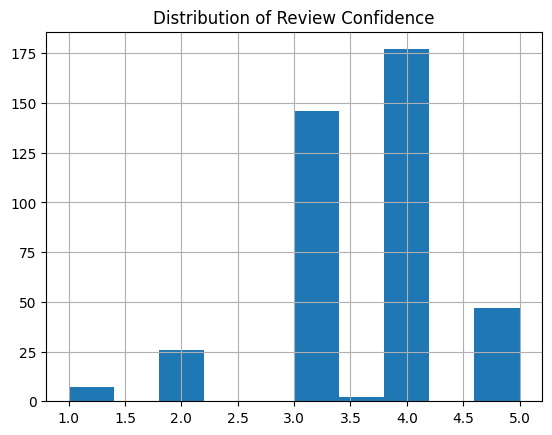

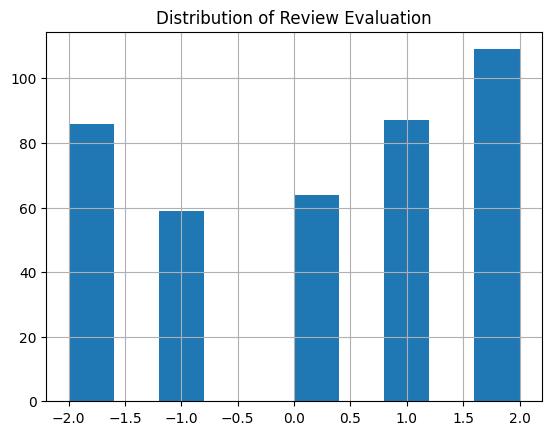

In [13]:
# ========= final cleaned data =========

print(df.describe(include='all'))

# Visualize numeric distributions
import matplotlib.pyplot as plt
df['review_confidence'].hist()
plt.title('Distribution of Review Confidence')
plt.show()

df['review_evaluation'].hist()
plt.title('Distribution of Review Evaluation')
plt.show()

# save cleaned data
df.to_csv("cleaned_paper_reviews.csv", index=False)
